In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!pip install --upgrade keras

     |████████████████████████████████| 378kB 9.2MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 42kB/s 


In [69]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [68]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 5590 (delta 15), reused 18 (delta 6), pack-reused 5557
Receiving objects: 100% (5590/5590), 13.35 MiB | 13.84 MiB/s, done.
Resolving deltas: 100% (3741/3741), done.


In [5]:
%cd /content/keras-retinanet

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170488 sha256=223bf81f6dffea8366bd8f1678665edd628002bdd6f44e0540bdbfa91fb942a2
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=508a383c6b0db2b9836e83c44ae26260720062a0da5d92d97a3659378c75bbb2
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [6]:
!python3 setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

os.makedirs("snapshots", exist_ok=True)

In [0]:
# 이미지 확장자 통일
import glob
files = glob.glob('/content/keras-retinanet/custom/images/*.JPG')
for x in files:
 if not os.path.isdir(x):
  filename = os.path.splitext(x)
  os.rename(x, filename[0]  + '.jpg')



In [0]:
%cd /content/keras-retinanet/custom

/content/keras-retinanet/custom


In [0]:
import glob
from os import getcwd
import xml.etree.ElementTree as ET

def convert_voc_2_darknet(data_folder_name, converted_file_name):
  
  def load_classes():
      with open('%s/classes.txt'%(data_folder_name)) as f:
          classes = f.read().splitlines()

      return classes

  def convert_annotation(image_id, converted_file):
      tree=ET.parse('%s/annotation/%s.xml'%(data_folder_name, image_id)) #xml 파일 하나 열기
      root = tree.getroot()

      for obj in root.iter('object'): #xml내에 object 태그 읽기
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox') #bndbox 추출
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text)) #4개 좌표값 받기
          converted_file.write("," + ",".join([str(a) for a in b]) + ',' + str(cls))

  # classes = ['tooth', 'decayed', 'cured']
  classes = load_classes()


  # image_ids = ['101', '102', ... '305']
  image_ids = [ f.replace(".xml", "").replace("%s/annotation/"%(data_folder_name), "") for f in glob.glob('%s/annotation/*.xml'%(DATA_FOLDER_NAME))]


  wd = getcwd()


  converted_file = open(converted_file_name, 'w')
  for image_id in image_ids:
      converted_file.write('%s/images/%s.jpg'%(data_folder_name, image_id))
      convert_annotation(image_id, converted_file)
      converted_file.write('\n')
  converted_file.close()


DATA_FOLDER_NAME = "/content/keras-retinanet/medical_receipt"
CONVERTED_FILE_NAME = "train_all.txt"

convert_voc_2_darknet(DATA_FOLDER_NAME, CONVERTED_FILE_NAME)


In [0]:
import pandas as pd

df = pd.read_csv('train_all.txt',names=['image_name', 'x_min','y_min','x_max','y_max', 'class_name'])

In [10]:
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,/content/keras-retinanet/medical_receipt/image...,435,43,1240,100,medical_receipt
1,/content/keras-retinanet/medical_receipt/image...,76,78,297,102,medical_receipt
2,/content/keras-retinanet/medical_receipt/image...,295,100,1354,155,medical_receipt
3,/content/keras-retinanet/medical_receipt/image...,75,76,297,101,medical_receipt
4,/content/keras-retinanet/medical_receipt/image...,397,11,1874,85,medical_receipt


In [0]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 0, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

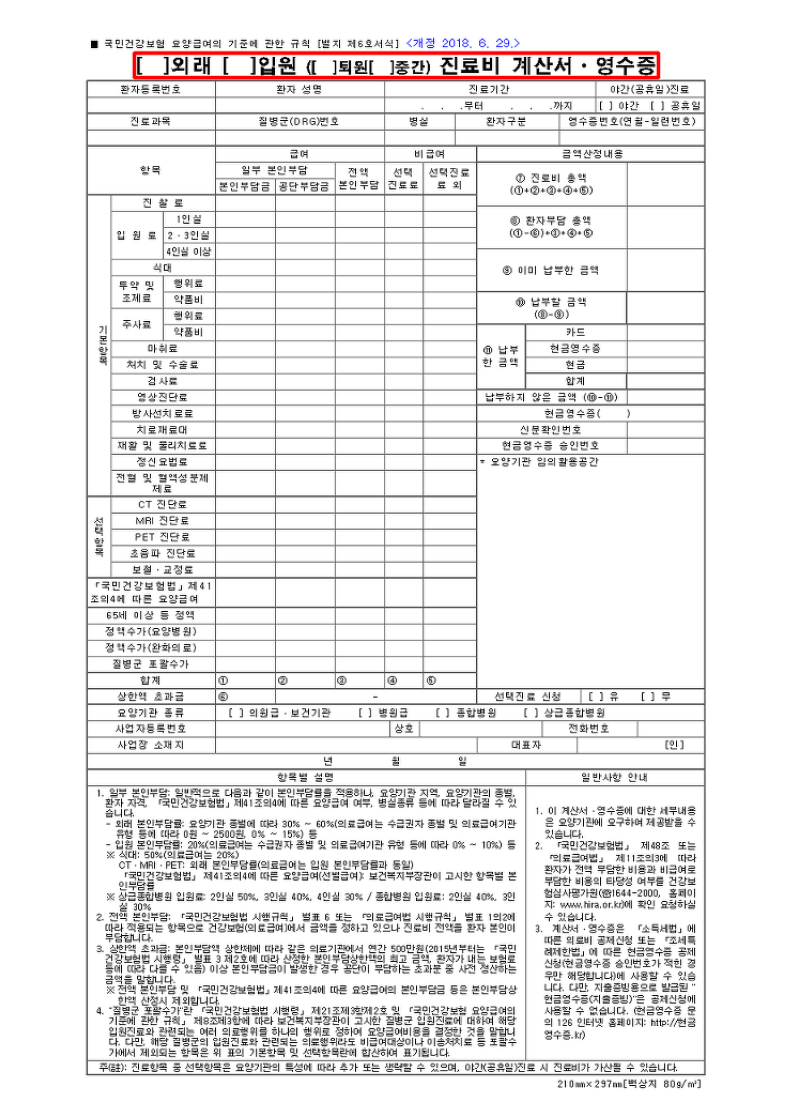

In [42]:
show_image_objects(train_df.iloc[10])

In [0]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.1, 
  random_state=RANDOM_SEED
)

In [16]:
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
17,/content/keras-retinanet/medical_receipt/image...,266,297,1388,363,medical_receipt
52,/content/keras-retinanet/medical_receipt/image...,215,135,1273,202,medical_receipt
3,/content/keras-retinanet/medical_receipt/image...,75,76,297,101,medical_receipt
32,/content/keras-retinanet/medical_receipt/image...,64,31,935,83,medical_receipt
13,/content/keras-retinanet/medical_receipt/image...,224,152,438,169,medical_receipt


In [0]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [0]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [19]:
!head annotations.csv

/content/keras-retinanet/medical_receipt/images/AIG_-32.jpg,266,297,1388,363,medical_receipt
/content/keras-retinanet/medical_receipt/images/AIG-05.jpg,215,135,1273,202,medical_receipt
/content/keras-retinanet/medical_receipt/images/receipt6.jpg,75,76,297,101,medical_receipt
/content/keras-retinanet/medical_receipt/images/AIG-02.jpg,64,31,935,83,medical_receipt
/content/keras-retinanet/medical_receipt/images/receipt23.jpg,224,152,438,169,medical_receipt
/content/keras-retinanet/medical_receipt/images/receipt30.jpg,34,16,399,33,medical_receipt
/content/keras-retinanet/medical_receipt/images/AIG-07.jpg,283,129,1351,192,medical_receipt
/content/keras-retinanet/medical_receipt/images/AIG_-10.jpg,105,26,975,74,medical_receipt
/content/keras-retinanet/medical_receipt/images/AIG_-14.jpg,283,100,1348,163,medical_receipt
/content/keras-retinanet/medical_receipt/images/0936_001.jpg,397,11,1874,85,medical_receipt


In [0]:
classes = set(['medical_receipt'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [21]:
!head classes.csv

medical_receipt,0


In [22]:
!pwd

/content/keras-retinanet


In [0]:
%cd /content/keras-retinanet

/content/keras-retinanet


In [23]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [0]:
!pwd
%cd /content/keras-retinanet/custom

/content/keras-retinanet
/content/keras-retinanet/custom


In [0]:
%cd /content/drive/My\ Drive

In [0]:
PRETRAINED_MODEL = '/content/keras-retinanet/snapshots/_pretrained_model.h5'

In [70]:
!python3 /content/keras-retinanet/keras_retinanet/bin/train.py \
  --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 8 \
  --steps 500 \
  --epochs 20 \
    csv annotations.csv classes.csv

Using TensorFlow backend.
2020-03-23 02:53:45.025148: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-03-23 02:53:45.025276: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-03-23 02:53:45.025300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Creating model, this may take a second...
2020-03-23 02:53:45.964320: W tensorflow/compiler/xla/service/platform_util.cc:276] unable to create StreamExecutor for CUDA:0: failed initia

In [0]:
!ls snapshots

resnet50_csv_01.h5  resnet50_csv_04.h5	resnet50_csv_07.h5  resnet50_csv_10.h5
resnet50_csv_02.h5  resnet50_csv_05.h5	resnet50_csv_08.h5
resnet50_csv_03.h5  resnet50_csv_06.h5	resnet50_csv_09.h5


In [25]:
model_path = '/content/keras-retinanet/snapshots/resnet50_csv_01.h5' #os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

/content/keras-retinanet/snapshots/resnet50_csv_01.h5


Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [26]:
labels_to_names

{0: 'medical_receipt'}

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:
THRES_SCORE = 0.02

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 0, 0))

  draw_detections(draw, boxes, scores, labels)
  plt.figure(figsize=(20,20))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [30]:
test_df.head(n=10)

,image_name,x_min,y_min,x_max,y_max,class_name
19,/content/keras-retinanet/medical_receipt/image...,106,21,294,32,medical_receipt
49,/content/keras-retinanet/medical_receipt/image...,123,9,1154,65,medical_receipt
48,/content/keras-retinanet/medical_receipt/image...,402,163,2028,272,medical_receipt
12,/content/keras-retinanet/medical_receipt/image...,458,116,2030,188,medical_receipt
44,/content/keras-retinanet/medical_receipt/image...,72,44,329,60,medical_receipt
5,/content/keras-retinanet/medical_receipt/image...,75,6,455,33,medical_receipt


In [0]:
test_df.shape

(33, 6)

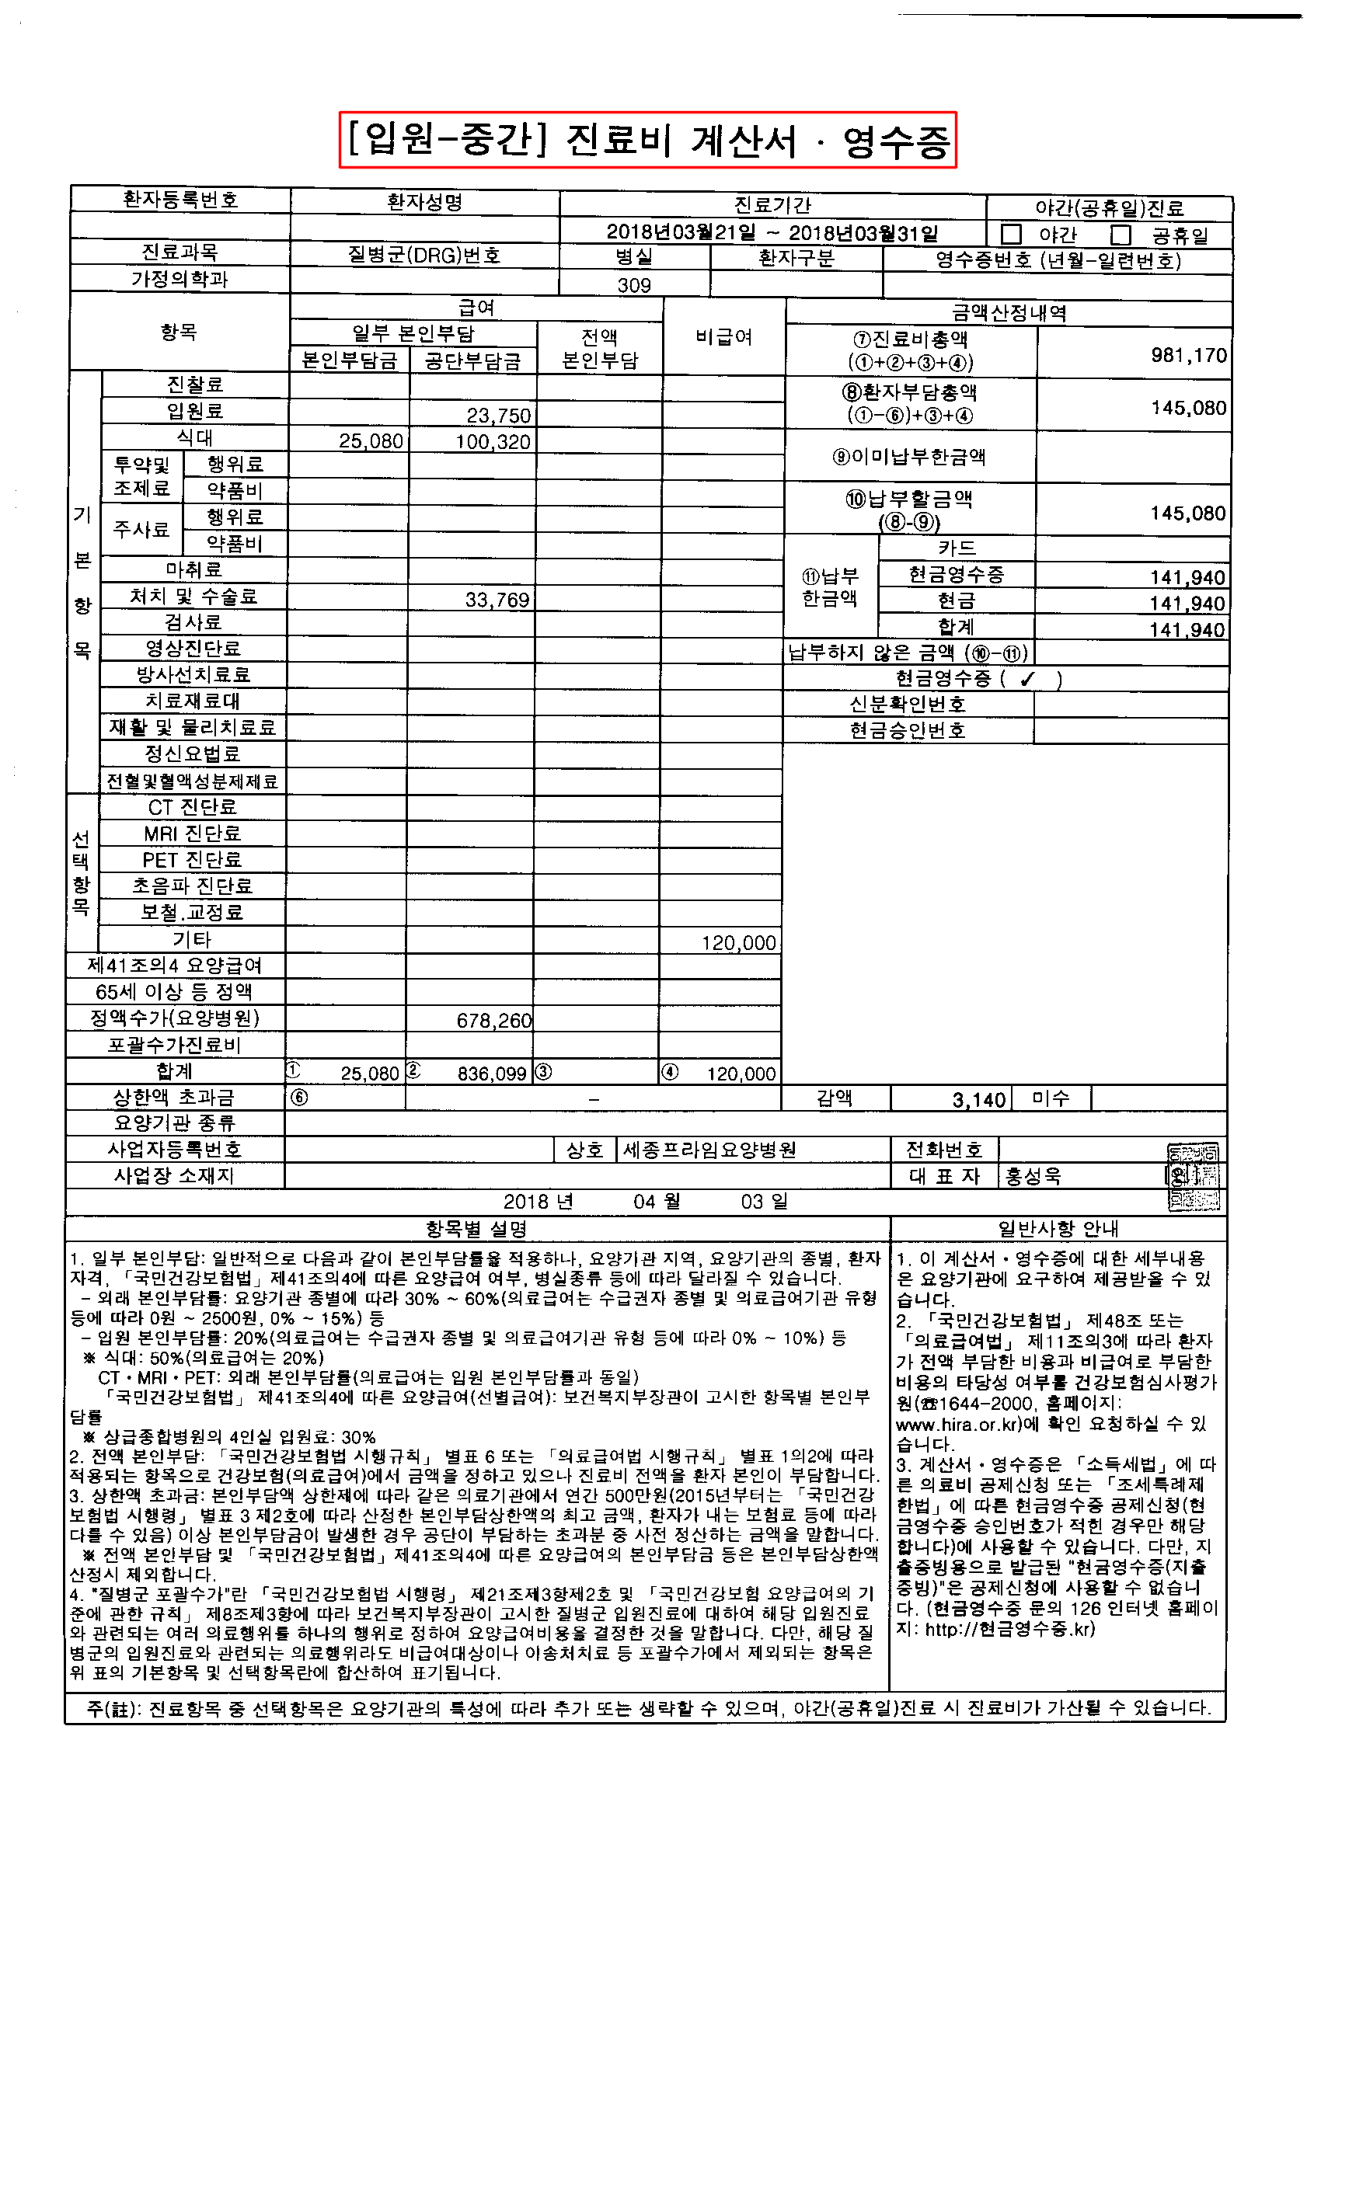

In [65]:
show_detected_objects(train_df.iloc[32])

In [0]:
  img_path = test_df.iloc[2].image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)